<a id='top'></a>
# calwebb_detector2 step-by-step notebook
---
For running on a single file

**Author**: Jonathan Aguilar (jaguilar@stsci.edu) | **Latest Update**: 23 Oct 2023

* [Introduction](#intro)
* [Pipeline Resources and Documentation](#resources)
* [Imports](#imports)
* [Convenience tools](#convenience_tools)
* [File selection](#file_selection)
* [Run the individual pipeline steps](#image2_step_by_step)
   * [Import the pipeline steps](#import_pipeline)
   * [The `Background Subtraction` step](#bkg_subtract)
   * [The `Assign WCS` step](#assign_wcs)
   * [The `Flat Fielding` step](#flatfield)
   * [The `Photometric Scaling` step](#photom)
   * [Saving to cal/calints](#close_out)

<a id='intro'></a>
## Introduction

The Stage 2 JWST pipeline for coronagraphy takes a `rateints` pipeline product as input, and performs the operations necessary to convert the units of the pixel counts into `MJy/sr`. These include:
- background subtraction, to remove background flux
- WCS assignment, to transform between pixel and sky coordinates
- flat fielding, to normalize pixel sensitivities
- photometric calibration, to scale DN/s to MJy/sr

The input `rateints` dataproduct consists of a 3-D slope cube that has units of DN/s, where DN stands for Data Number, a unit used to label uncalibrated counts coming from the detector readout electronics.

This notebook breaks the calwebb_image2 (also called Image2Pipeline) pipeline class into steps, runs each step independently, and examines the output. It demonstrates how to change step-specific parameters at the step level. Much of the material, especially the documentation, is based on the example notebook found [here](https://github.com/spacetelescope/jwebbinar_prep/blob/main/pipeline_inflight/imaging_mode_stage_2.ipynb), written by Bryan Hilbert. Materials and videos can be found [here](https://www.stsci.edu/jwst/science-execution/jwebbinars) under JWebbinar 18. Here, it has been tailored to the specific case of MIRI coronagraphy.

Since this notebook focuses on running a single file through the pipeline, it skips the background subtraction step, which requires background exposures. For examples that include background subtraction, please see the following notebooks:

<a id='resources'></a>
## Pipeline resources and documentation

Documentation on `calwebb_image2` and the steps run on MIRI coronagraphy data specifically can be found here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html

We also refer the user to the Imaging example notebook: https://github.com/spacetelescope/jwebbinar_prep/blob/main/pipeline_inflight/imaging_mode_stage_2.ipynb. This contains a wealth of information that has been omitted here for brevity.




<a id='imports'></a>
## Non-pipeline imports

In [1]:
import os
from collections import OrderedDict
from pathlib import Path

In [2]:
import numpy as np

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits

<a id='convenience_tools'></a>
## Convenience tools

Environment paths and functions that make life easier.

First, set up a local CRDS directory. When the pipeline pulls a reference file from CRDS for the first time, it will write a copy to this directory. All subsequent reads of the reference file will redirect to the local directory instead of sending the file again over the network.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/reference_files_crds.html#crds

In [4]:
os.environ['CRDS_PATH'] = '/Volumes/agdisk/crds/'
# os.environ['CRDS_PATH'] = ''
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Advanced users - uncomment the cell below and specify the context if you have a specific combination of reference files you want to use

In [5]:
# os.environ['CRDS_CONTEXT'] = 'jwst_1140.pmap'

In [6]:
# some plot formatting
mpl.rcParams['image.origin'] = "lower"

In [7]:
# you may need to run this command twice for plots to pop up correctly
# %matplotlib auto
%matplotlib inline

### Logging configuration

The logging statements can be quite extensive, which can make a notebook cumbersome to read on Github in an executed state. To help the users, we're going to redirect the logging statements to log files stored in each step's output folder. That way you the notebook will be stripped down to the commands and diagnostic output, but the logging statements are preserved so users can compare them against the output in their own notebooks. 

In the cell below you'll find the template to the logging configuration file. The logging configuration file contains the path to the log file and the level of verbosity. At each step, we will call the `generate_log_file` function to create a config file, and pass that file to the step. The step will then generate a log file in the output directory.

In [8]:
cfg_template = """
[*]
handler = file:path_to_file
level = INFO
"""
def generate_log_file(output_dir):
    cfgfile_name = Path(output_dir).stem + ".cfg"
    logfile_name = Path(output_dir).stem + ".log"
    cfg = cfg_template.replace("path_to_file", str(output_dir / logfile_name))
    cfgfile_path = output_dir / cfgfile_name
    with open(str(cfgfile_path), 'w') as f:
        f.write(cfg)
    return str(cfgfile_path) if cfgfile_path.exists() else None

<a id="file_selection"></a>
## Collect Stage 1 product

By default, this notebook uses one of the results of the `calwebb_detector1-all_exposures.ipynb` notebook. If you wish to use a file on your own system, please replace the `rate_file` path in the cell below. 

If you have not run the Stage 1 notebook but you would still like to use this specific exposure as an example, you can retrieve it directly from MAST with the code snippet below.

<div class="alert alert-block alert-info">
Snippet for downloading Stage 1 ERS-1386 data:

```
from astroquery.mast import Observations
filename = "jw01386007001_04101_00001_mirimage_rateints.fits"
Observations.download_file(f"mast:JWST/product/{filename}", local_path= f"./stage1/input/{filename}")
rate_file = f"./stage1/input/{filename}"
```
    
</div>

In [9]:
rate_file = "stage1/output/jw01386008001_04101_00001_mirimage_rateints.fits"

Let's do a quick inspection of the file

In [10]:
# print some basic information
fits.info(rate_file)

Filename: stage1/output/jw01386008001_04101_00001_mirimage_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     238   ()      
  1  SCI           1 ImageHDU        76   (288, 224, 60)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 60)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 60)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   60R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (288, 224, 60)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (288, 224, 60)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [8162B]   


/var/folders/hr/1pqv7tg94gvbhpcgq7c2fb_r0001bw/T/ipykernel_35319/2379753796.py:3: RuntimeWarning: Mean of empty slice
  img = np.nanmean(fits.getdata(rate_file, 1), axis=0)


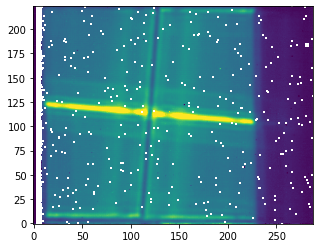

In [11]:
# a simple plot
fig, ax = plt.subplots(1, 1)
img = np.nanmean(fits.getdata(rate_file, 1), axis=0)
imlims = dict(zip(['vmin', 'vmax'], np.nanquantile(img, [0.01, 0.99])))
ax.imshow(img, **imlims, origin='lower')

<a id='image2_step_by_step'></a>
## Run each step of calwebb_image2

We're going to save the output of each step separately, so the code below generates an output folder for each step. We will be running only the steps that are relevant to the MIRI coronagraphy pipeline. All the provided parameter values are the default values.

The steps, in order of execution, are:
- `bkg_subtract`
    - performs background subtraction
    - takes as input a datamodel and an optional list of background exposure filenames
    - returns datamodel with the backgorund exposures subtracted
    - step-specific arguments:
        - `sigma float [3.0]`: std for sigma-clipping
        - `maxiters int [None]`: number of clipping iterations to perform when combining multiple background images
        - `save_combined_background bool [False]`: save the master background, or no
        - `wfss_mmag_extract tuple [None]`: only for WFSS exposures; sets min mag for extracting sources
- `assign_wcs`
    - associates a WCS object with each the exposure
    - keywords used: RA_REF, DEC_REF, V2_REF, V3_REF, ROLL_REF, RADESYS
    - no step-specific arguments    
    - reference files used:
        - DISTORTION
        - FILTEROFFSET
 
- `flat_field`
    - multiplies by a flat field reference image to mitigate pixel-to-pixel sensitivity differences
    - step-specific arguments:
        - `save_interpolated_flat bool [False]`: only for NIRSpec; save the flat-field that was constructed on the fly
        - `user_supplied_flat str [None`: path to a user-supplied flat-field image to use
        - `inverse bool [False]`: multiply isntead of divide
    - reference files used:
        - FLAT
        
- `photom`
    - scales the data by a conversion factor between units of countrate to units of surface brightness 
    - step-specific arguments:
        - `inverse bool [False]`: divide instead of multiply
        - `source_type str [None]`: force processing for POINT or EXTENDED sources
        - `mrs_time_correction bool [True]`: turn on or off time-dependent correction for MRS sensitivity decay
    - reference files used:
        - PHOTOM

<a id='import_pipeline'></a>
### Import the pipeline steps

In [12]:
import jwst
jwst.__version__

'1.11.3'

In [13]:
from jwst import datamodels
from jwst.datamodels import dqflags

In [14]:
from jwst.pipeline import Image2Pipeline
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep 
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from jwst.resample import ResampleStep

We're going to write out the results of each step to disk, and also keep a copy in memory in the `results` dict generated in the cell below.

In [15]:
# Create a dictionary for storing the intermediate results.

# The get_pars() method returns a dictionary of allowed parameters for the pipeline stage, including
# a dictionary of parameters for each step. We will use this dictionary to get a list of steps that will
# index our results dictionary.
results = OrderedDict([(step, None) for step in Image2Pipeline().get_pars()['steps'].keys()])
results.pop("resample") # the resample step isn't run

2023-11-16 11:52:09,576 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2023-11-16 11:52:09,577 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-16 11:52:09,579 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-16 11:52:09,581 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2023-11-16 11:52:09,582 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2023-11-16 11:52:09,583 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


In [16]:
print("Here is a list of the different steps:")
for step in results.keys():
    print("\t" + step)

Here is a list of the different steps:
	bkg_subtract
	assign_wcs
	flat_field
	photom


Generate the output folders specific to this notebook

For this notebook, each step gets its own output folder: `stage2/output-steps//{step_name}`

In [17]:
for k in results.keys():
    p = Path(f"./stage2/output-steps/{k}")
    if not p.exists():
        p.mkdir(parents=True)
        print(str(p.resolve()), "made")
    else:
        print(f"{str(p)} found")

stage2/output-steps/bkg_subtract found
stage2/output-steps/assign_wcs found
stage2/output-steps/flat_field found
stage2/output-steps/photom found


ASDF datamodels are the native data format used by the pipeline, so we're going to use them here

In [18]:
init_dm = datamodels.open(rate_file)

Add the starting data to the results dict

In [19]:
results['init'] = init_dm

<a id='bkg_subtract'></a>
## Background subtraction

<div class="alert alert-block alert-info">
Note: for this notebook, where we explicitly choose to not combine multiple exposures, we skip the background subtraction step. The final data products from this notebook will have visible glowsticks.
</div>

https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step

The background subtraction step performs image-from-image subtraction in order to accomplish subtraction of background signal. The step takes as input one target exposure, to which the subtraction will be applied, and a list of one or more background exposures.

There are 4 optional arguments:
- sigma: std for sigma-clipping
- maxiters: number of clipping iterations to perform when combining multiple background images
- save_combined_background: save the master background, or no
- wfss_mmag_extract: only for WFSS exposures; sets min mag for extracting sources

In [20]:
output_dir = Path(f"stage2/output-steps/bkg_subtract/")

In [21]:
results['bkg_subtract'] = BackgroundStep.call(
    results['init'],
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # For this case, we are going to skip it.
    skip=True
)

<a id='assign_wcs'></a>
## Assign WCS

https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

This step associates a WCS object with each science exposure. The WCS object transforms positions in the detector frame to positions in a world coordinate frame - ICRS and wavelength.

There are no step-specific optional arguments for AssignWCS.

In [22]:
output_dir = Path("stage2/output-steps/assign_wcs")

results['assign_wcs'] = AssignWcsStep.call(
    results["bkg_subtract"],
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),    
    # step-specific - None
)
    

In [23]:
dm = results['assign_wcs']

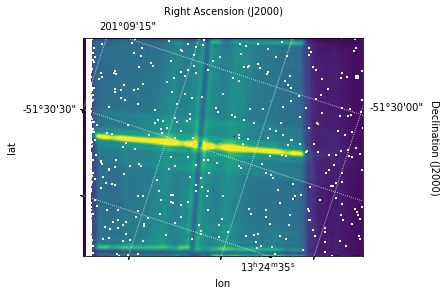

In [24]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': dm.meta.wcs})
img = np.nanmean(dm.data, axis=0)
imlims = dict(zip(['vmin', 'vmax'], np.nanquantile(img, [0.01, 0.99])))
ax.imshow(img, **imlims, origin='lower')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

<a id='flatfield'></a>
## Flat Fielding

https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step

At its basic level this step flat-fields an input science dataset by dividing by a flat-field reference image. 

Step-specfic arguments:

- save_interpolated_flat (boolean, default=False)
    - A flag to indicate whether to save to a file the NIRSpec flat field that was constructed on-the-fly by the step. Only relevant for NIRSpec data.
- user_supplied_flat (string, default=None)
    - The name of a user-supplied flat-field reference file.
- inverse (boolean, default=False)
    - indicate whether the math operations used to apply the flat-field should be inverted (i.e. multiply instead of divide).
    
<div class="alert alert-block alert-info">
    Note: The discovery of the stray light "glowstick" anomaly impacting the coronagraphs has made it challenging to derive a proper in-flight flat field reference file, since the stray light is an additive effect. The current flat field reference files were derived pre-flight. For this reason, they appear to *add* the glowsticks, especially in the 1065 and 1140 coronagraphs, but this is only a result of the decreased sensitivity along the quadrant boundaries.
</div>

In [25]:
output_dir = Path("stage2/output-steps/flat_field")

results['flat_field'] = FlatFieldStep.call(
    results['assign_wcs'],
    # common
    save_results=True, output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),    
    # step-specific
    save_interpolated_flat = False,
    user_supplied_flat = None,
    inverse = False    
)

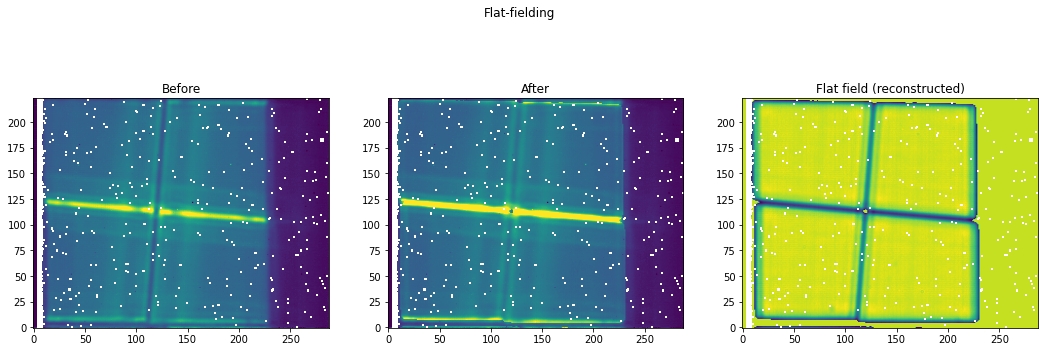

In [26]:
nrows, ncols = 1, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
fig.suptitle("Flat-fielding")

before_img = np.nanmean(results['assign_wcs'].data, axis=0)
after_img = np.nanmean(results['flat_field'].data, axis=0)
vmin, vmax = np.nanquantile([before_img, after_img], [0.01, 0.99])


ax = axes.flat[0]
ax.set_title("Before")
ax.imshow(before_img, vmin=vmin, vmax=vmax)

ax = axes.flat[1]
ax.set_title("After")
imax = ax.imshow(after_img, vmin=vmin, vmax=vmax)

ax = axes.flat[2]
ax.set_title("Flat field (reconstructed)")
imax = ax.imshow(before_img/after_img)

## photom

https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step

The photom step applies flux (photometric) calibrations to a data product to convert the data from units of countrate to surface brightness (or, in some cases described below, to units of flux density)

Step-specfic arguments:

- inverse (boolean, default=False)
    - A flag to indicate whether the math operations used to apply the correction should be inverted (i.e. divide the calibration data into the science data, instead of the usual multiplication).

- source_type (string, default=None)
    - Force the processing to use the given source type (POINT, EXTENDED), instead of using the information contained in the input data.

- mrs_time_correction (boolean, default=True)
    - A flag to indicate whether to turn on the time and wavelength dependent correction for MIRI MRS data.
    

In [27]:
output_dir = Path("stage2/output-steps/photom")

results['photom'] = PhotomStep.call(
    results['flat_field'],
    # common
    save_results=True, output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific - None
)
    

The ratio between the before and after images should look like the flat field reference file

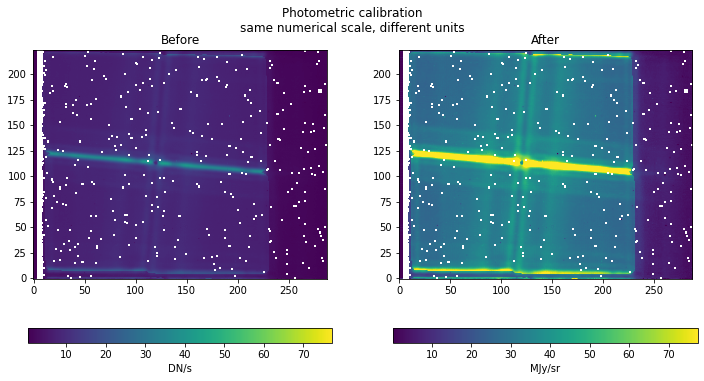

In [28]:
nrows, ncols = 1, 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
fig.suptitle("Photometric calibration\nsame numerical scale, different units")

before_img = np.nanmean(results['flat_field'].data, axis=0)
after_img = np.nanmean(results['photom'].data, axis=0)
vmin, vmax = np.nanquantile([after_img, before_img], [0.01, 0.99])

ax = axes[0]
ax.set_title("Before")
imax = ax.imshow(before_img, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(imax, ax=ax, orientation='horizontal')
cbar.set_label(results['flat_field'].meta.bunit_data)

ax = axes[1]
ax.set_title("After")
imax = ax.imshow(after_img, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(imax, ax=ax, orientation='horizontal')
cbar.set_label(results['photom'].meta.bunit_data)

<a id='close_out'></a>
## Close it out

Just so that we can end up with the proper *rate{ints}.fits* filenames

In [29]:
img2 = Image2Pipeline(output_dir="stage2/output-steps")

img2.save_model(results['flat_field'], 
                suffix="calints",
                output_file=results['flat_field'].meta.filename)

'stage2/output-steps/jw01386008001_04101_00001_mirimage_calints.fits'